In [351]:
import pandas
import os
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, linear_model

In [570]:
def PCA_LR_pipeline(in_mtx, y, pca = PCA(random_state=123), 
                    clf = linear_model.LassoCV(random_state = 123), 
                    cv_strategy = None, cv = 10, test_gene_num = [100], illustrative = False,
                   sanity_check_style = 'seperate'):
    
    final_outputs = {}
    
    if type(in_mtx) == pandas.core.frame.DataFrame:
        in_mtx = in_mtx.values
    
    if type(pca) == type(None):
        pca_tfm = in_mtx
    else:
        print('running PCA')
        dat_pca = pca.fit(in_mtx)
        print('transforming data')
        pca_tfm = dat_pca.transform(in_mtx)
        if len(y) != pca_tfm.shape[-1]:
            raise ValueError('length of y-axis of transformed item must match the length of y')
        final_outputs.update({'pca_object': dat_pca})
    
    
    
    print('performing model cross-validation')
    if hasattr(cv_strategy, 'get_n_splits'):
        folds = cv_strategy.get_n_splits(pca_tfm)
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, groups=folds, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, groups=folds, cv=cv)
        score = stats.pearsonr(predicted, y)[0]**2
    elif type(cv_strategy) != type(None):
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, cv=cv)
        score = stats.pearsonr(predicted, y)[0]**2
    else:
        score = None
    if type(score) != type(None):
        if illustrative:
            plt.close()
            sns.regplot(predicted, y, fit_reg=False)
            plt.xlabel('CV model predicted position along axis')
            plt.ylabel('Actual position along axis')
            plt.show()
        print('model cv score: r2 = ',score)
        final_outputs.update({'CV_scores': score})
    else:
        print('no valid cross-validation method specified')
    
    print('running final model')
    mod = clf.fit(pca_tfm, y)
    if not hasattr(mod,'coef_'):
        raise IOError('right now, this pipeline can only accept clf objects with a coef_ attribute')
    final_outputs.update({'final_model': mod})
    scr = mod.score(pca_tfm, y)
    if illustrative:
        print('final model fit r2 = ',scr)
    
    if type(pca) == type(None):
        f_betas = mod.coef_
    else:
        f_betas = back_transform(dat_pca, mod)
    final_outputs.update({'betas': f_betas})
    
    gene_selections = sanity_check(in_mtx, y, f_betas, test_gene_num, 
                                   illustrative, sanity_check_style)
    final_outputs.update({'gene_selections': gene_selections})
    
    return final_outputs
    
def back_transform(pca_obj, clf_obj):
    return np.dot(pca_obj.components_.T,clf_obj.coef_)

def sanity_check(in_mtx, y, betas, test_gene_num, illustrative, sanity_check_style):
    
    if sanity_check_style == 'separate':
        ascores = []
        pscores = []
    else:
        scores = []
    print('running sanity_check')
    betas = pandas.Series(betas)
    outputs = {}
    for num in test_gene_num:
      
        p_chk = betas.sort_values(ascending=False)[:num].index
        a_chk = betas.sort_values(ascending=False)[-num:].index

        pchk_vals = []
        achk_vals = []
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in p_chk:
                to_avg.append(in_mtx[sample,gene])
            pchk_vals.append(np.mean(to_avg))
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in a_chk:
                to_avg.append(in_mtx[sample,gene])
            if sanity_check_style == 'separate':
                achk_vals.append(np.mean(to_avg))
            else:
                achk_vals.append(np.mean(to_avg) * -1)

        if sanity_check_style != 'separate':
            chk_vals = np.array(pchk_vals) + np.array(achk_vals)
            
        if sanity_check_style == 'separate':
            pr,pp = stats.pearsonr(pchk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(pchk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of posterior direction genes')
                plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
            print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, pr**2, pp))

            ar,ap = stats.pearsonr(achk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(achk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of anterior direction genes')
                plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
            print('anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, ar**2, ap))
            
        else:
            r,p = stats.pearsonr(chk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(chk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of A-P axis genes')
                plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
            print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, r**2, p))
            
        if sanity_check_style == 'separate':
            ascores.append(ar**2)
            pscores.append(pr**2)
        else:
            scores.append(r**2)
        outputs.update({'posterior_genes_%s'%num: p_chk}) 
        outputs.update({'anterior_genes_%s'%num: a_chk})
            
    if len(test_gene_num) > 1:
        if sanity_check_style == 'separate':
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(ascores),
                                pandas.Series(pscores)],axis=1)
            jnk.columns = ['num','a','p']

            plt.close()
            fig,(ax1,ax2) = plt.subplots(2, figsize=(8,10))
            sns.factorplot(x='num', y='a', data=jnk, ax=ax1)
            sns.factorplot(x='num', y='p', data=jnk, ax=ax2)
            ax1.set(xlabel = 'Number of posterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            ax2.set(xlabel = 'Number of anterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()
        else:
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(scores)
                                ],axis=1)
            jnk.columns = ['num','score']

            plt.close()
            fig,ax1 = plt.subplots(1, figsize=(8,10))
            sns.factorplot(x='num', y='score', data=jnk, ax=ax1)
            ax1.set(xlabel = 'Number of genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()

    return outputs




In [3]:
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

In [559]:
p_chk = pandas.Series(betas).sort_values(ascending=False)[:100].index
a_chk = pandas.Series(betas).sort_values(ascending=False)[-100:].index


In [73]:
def make_sphere(coord, radius):
    summers = []
    negrad = (radius*-1)+1
    for x in itertools.product(range(negrad,radius),repeat=3):
        summers.append(np.array(x))
    s_coords = [np.array(coord) + x for x in summers]
    xs = [int(x[0]) for x in s_coords]
    ys = [int(x[1]) for x in s_coords]
    zs = [int(x[2]) for x in s_coords]
    
    return xs, ys, zs

In [6]:
wdir = '/Users/jakevogel/Science/AHBA/'
xp = pandas.read_csv(os.path.join(wdir,'whole_hippocampus_xp_allsubs_cleaned_labeled.csv'))
df = pandas.read_csv(os.path.join(
        wdir,'whole_hippocampus_hit_coordinates_cleaned_all_c_labs.csv'))
df = df.loc[[x for x in df.index if pandas.notnull(df.loc[x,'2_c_solution'])]]
df.drop(df.index[0],inplace=True)
gdf = pandas.read_csv(os.path.join(wdir,'gxp_correlation_wholebrain_results.csv'))



running PCA
transforming data
performing model cross-validation


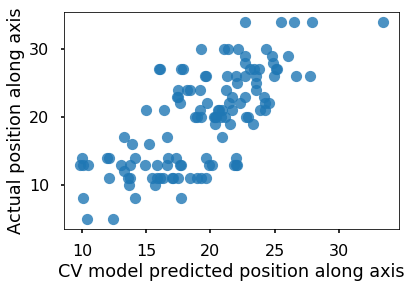

model cv score: r2 =  0.508472846755
running final model
final model fit r2 =  0.821098120088
running sanity_check


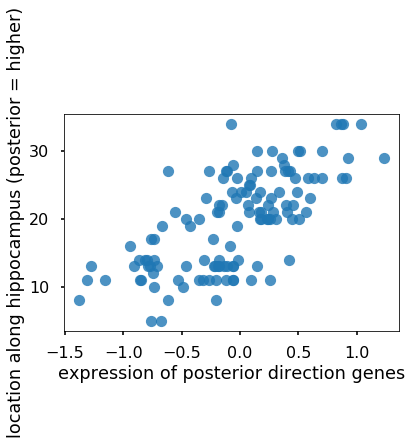

posterior 100 genes vs. y:  r2 = 0.481591211315, p = 4.05370013879e-19 




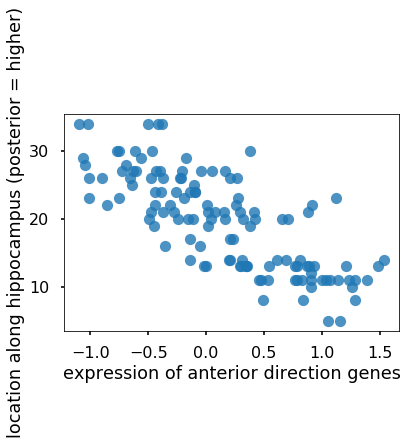

anterior 100 genes vs. y:  r2 = 0.60135955108, p = 3.9946085745e-26 




In [316]:
pcalr_out = PCA_LR_pipeline(xp.loc[xp.index[:-6]].values.T, 
                            df.hip_axis_loc_posterior_high, 
                           cv_strategy='score', illustrative=True)

In [8]:
probes = pandas.read_csv(
        '/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')

In [9]:
pcalr_out.keys()

dict_keys(['CV_scores', 'pca_object', 'gene_selections', 'final_model', 'betas'])

In [11]:
pcalr_out['gene_selections']

{'anterior_genes': Int64Index([ 3011, 54487, 23553,  3009, 47032, 32963, 46817, 46816,  3403,
              8403, 44853,  4984,  8441, 23351,  3405, 22938, 33560,  8448,
             49834, 25592, 11928, 55893,  6728, 29196,  3404, 47041, 42892,
             24484, 44179, 33442, 11605, 35456, 35940,  8230, 10216, 56375,
             35035,  8447, 42596, 23551, 56215,  3668, 25455, 25839,  1939,
              4398, 15471, 11603, 32711, 35522, 34958, 23817, 44020, 40112,
              8442, 24685, 22108, 27224, 26855, 42730, 43970,  8692,  6189,
             40303,  1940, 24482, 15811,  8691, 35503, 44435, 35520, 40987,
             34235, 47645, 40910, 37571,  3225,  1954,  2781,  3182, 35379,
             52670, 44735, 25771, 51984, 15812, 28306, 28521, 36265, 14245,
             14246, 20529, 53734, 25772, 14244, 23274, 22478, 25103,  4417,
              4418],
            dtype='int64'),
 'posterior_genes': Int64Index([ 6582, 51664, 32888, 32889, 16389, 16390,  8892, 43820,  8893,
  

In [51]:
probes.loc[pcalr_out['gene_selections']['anterior_genes'],'gene_symbol'
          ].unique().tolist()

['IGFBP6',
 'A_32_P115840',
 'SEMA3D',
 'IGFBP5',
 'CHRM5',
 'ADAMTSL1',
 'GRP',
 'MET',
 'BAIAP3',
 'ATP2B4',
 'PTPRG',
 'SLIT2',
 'NUDT10',
 'DNAH12',
 'PTGFR',
 'ITGBL1',
 'A_24_P945165',
 'NRG1',
 'RGS22',
 'A_24_P17052',
 'TDO2',
 'TRIM54',
 'CHRNA3',
 'AC078937.4',
 'RSPO2',
 'PLAC2',
 'FLJ38379',
 'C20orf103',
 'FAM148C',
 'PTER',
 'GPR83',
 'PTGES',
 'ANKRD62',
 'CD36',
 'A_24_P925505',
 'MYB',
 'TMEM215',
 'MYO16',
 'GPR26',
 'SLC26A4',
 'GABRQ',
 'PTGER3',
 'ATOH7',
 'LOC100129291',
 'NR2F2',
 'PYDC1',
 'CCBE1',
 'RP11-45B20.3',
 'GHSR',
 'PIRT',
 'GDA',
 'SSTR1',
 'LXN',
 'AQP3',
 'MLPH',
 'A_24_P673968',
 'KIAA1772',
 'LMO1',
 'GPR39',
 'KCNG1',
 'LGALS2',
 'A_24_P931017',
 'KLK7',
 'A_23_P213527',
 'C1QL1',
 'TOX3',
 'SYTL2',
 'LYPD1',
 'C1orf187',
 'RSPH9',
 'RP13-102H20.1',
 'VGLL3',
 'SERPINF1']

In [50]:
probes.loc[pcalr_out['gene_selections']['anterior_genes'],'entrez_id'
          ].unique().astype(int).tolist()

ValueError: invalid literal for int() with base 10: 'IGFBP6'

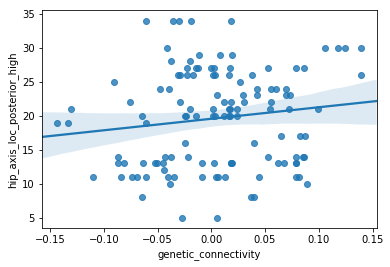

In [22]:
hipp_rs = gdf.loc[df.label.values,'genetic_connectivity']
plt.close()
sns.regplot(hipp_rs,df.hip_axis_loc_posterior_high)
plt.show()

In [28]:
y = df.hip_axis_loc_posterior_high

In [30]:
rs = []
dists = []
for i,samp in enumerate(xp.columns):
    svec = xp.loc[xp.index[:-6],samp]
    refvec = pcalr_out['betas']
    r,p = stats.pearsonr(svec,refvec)
    print('sample %s, r = %s, dist = %s'%(samp, r, y.iloc[i]))
    rs.append(r)
    dists.append(y.iloc[i])

sample 10021_lab_1.0_samp_524, r = -0.0810802932172, dist = 13.0
sample 10021_lab_1.0_samp_525, r = -0.0447616705996, dist = 13.0
sample 10021_lab_1.0_samp_527, r = -0.044307079294, dist = 12.0
sample 10021_lab_1.0_samp_528, r = -0.0737376839338, dist = 11.0
sample 10021_lab_1.0_samp_531, r = 0.0784252893222, dist = 27.0
sample 10021_lab_1.0_samp_532, r = 0.0527090815613, dist = 27.0
sample 10021_lab_1.0_samp_533, r = 0.0861678959176, dist = 27.0
sample 10021_lab_1.0_samp_534, r = 0.139132381259, dist = 26.0
sample 10021_lab_1.0_samp_544, r = 0.0605975650645, dist = 24.0
sample 10021_lab_1.0_samp_545, r = 0.0697063924269, dist = 24.0
sample 10021_lab_1.0_samp_546, r = 0.0558090712294, dist = 24.0
sample 10021_lab_1.0_samp_547, r = 0.0424186555562, dist = 24.0
sample 10021_lab_1.0_samp_558, r = 0.00202659357689, dist = 21.0
sample 10021_lab_1.0_samp_559, r = -0.0287553196267, dist = 22.0
sample 10021_lab_1.0_samp_561, r = 0.00294620354779, dist = 13.0
sample 10021_lab_1.0_samp_562, r = 

In [31]:
stats.pearsonr(rs,dists)

(0.91889136548696992, 4.10325955142171e-51)

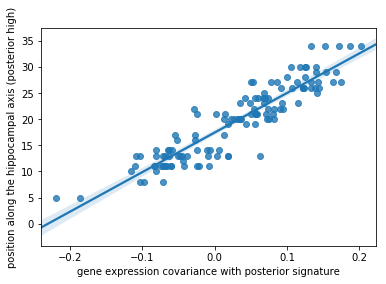

In [34]:
plt.close()
sns.regplot(np.array(rs),np.array(dists))
plt.xlabel('gene expression covariance with posterior signature')
plt.ylabel('position along the hippocampal axis (posterior high)')
plt.show()

In [36]:
gdf.head()

,genetic_connectivity,donor,sample,structure_id,slab_num,well_id,slab_type,structure_acronym,structure_name,polygon_id,mri_voxel_x,mri_voxel_y,mri_voxel_z,mni_x,mni_y,mni_z
0,-0.116131,10021,1,4322,10,5705,CX,Cl,"claustrum, left",978619,120,91,71,-29.2,5.8,-2.6
1,-0.018835,10021,2,4291,10,5713,CX,Acb,"nucleus accumbens, left",998603,103,96,71,-10.1,5.9,-8.4
2,-0.002381,10021,3,4292,10,5721,CX,Acb,"nucleus accumbens, right",998604,86,95,69,8.9,8.5,-7.4
3,-0.031887,10021,4,4292,11,5729,CX,Acb,"nucleus accumbens, right",999200,87,95,76,7.9,0.8,-6.7
4,-0.039106,10021,5,4314,11,5737,CX,SI,"substantia innominata, right",992030,79,97,76,16.9,0.9,-9.1


In [37]:
roi_res = pandas.DataFrame(index=gdf.structure_acronym.unique(), columns = ['avg_r'])
roi_res.head()


,avg_r
Cl,NaN
Acb,NaN
SI,NaN
GPe,NaN
LA,NaN


'Cl'

In [46]:
for roi in roi_res.index:
    roi_res.loc[roi,'avg_r'] = gdf[gdf.structure_acronym==roi]['genetic_connectivity'].mean()
    roi_res.loc[roi,'example_name'] = gdf[gdf.structure_acronym==roi]['structure_name'].values[0]

In [49]:
roi_res.sort_values('avg_r')

,avg_r,example_name
ATZ,-0.137161,"amygdalohippocampal transition zone, right"
PTG,-0.121358,"paraterminal gyrus, right"
BMA,-0.103305,"basomedial nucleus, right"
BLA,-0.0985869,"basolateral nucleus, right"
VMH,-0.0953357,"ventromedial hypothalamic nucleus, left"
Pir,-0.0946619,"piriform cortex, left"
DMH,-0.0913674,"dorsomedial hypothalamic nucleus, left"
COMA,-0.0908278,"cortico-medial group, left"
TP-s,-0.0887033,"temporal pole, right, superior aspect"
LHT,-0.0842844,"lateral hypothalamic area, tuberal region, left"


In [55]:
d_classifiers = pandas.DataFrame(index = range(9,34), columns = ['accuracy'])
for i in range(9,34):
    classes = [0 if x < i else 1 for x in y]
    tmod = linear_model.LogisticRegressionCV().fit(np.array(rs).reshape(-1,1),classes)
    scr = tmod.score(np.array(rs).reshape(-1,1),classes)
    d_classifiers.loc[i,'accuracy'] = scr
d_classifiers.loc[:,'distance'] = d_classifiers.index

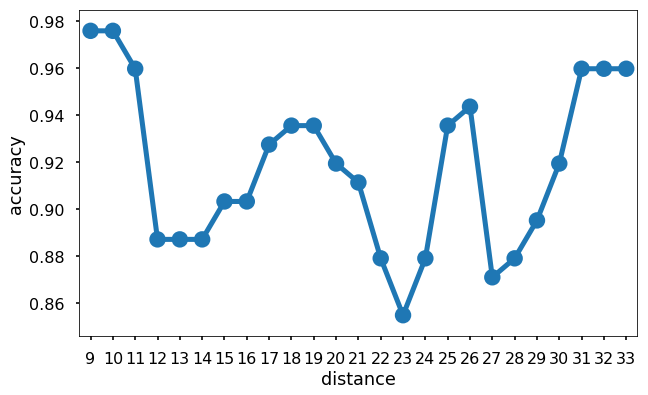

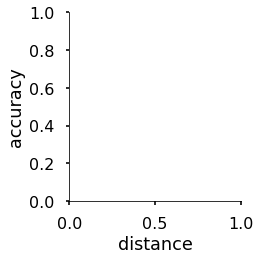

In [64]:
plt.close()
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(10,6))
sns.factorplot(x='distance', y='accuracy', data=d_classifiers, ax=ax)
plt.show()

In [389]:
print(len(df.loc[[x for x in df.index if df.hip_axis_loc_posterior_high[x] < 12]
                ][['x','y','z']]))
print(len(df.loc[[x for x in df.index if df.hip_axis_loc_posterior_high[x] > 29]
                ][['x','y','z']]))

21
10


In [393]:
df.loc[[x for x in df.index if df.hip_axis_loc_posterior_high[x] < 12]].index

Int64Index([  4,  25,  34,  35,  38,  39,  44,  45,  59,  64,  65,  69,  70,
             72,  73,  74,  78,  83,  84, 103, 130],
           dtype='int64')

In [391]:
df.to_csv(os.path.join(
        wdir,'whole_hippocampus_hit_coordinates_cleaned_all_c_labs.csv'))

In [533]:
def run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 5,
                                  in_imgs = [], bootstrap = False):
    
    if len(in_imgs) == 0:
        a_idx = df.loc[[x for x in df.index if df.loc[x,ycol] < ant_cut]].index
        p_idx = df.loc[[x for x in df.index if df.loc[x,ycol] > post_cut]].index
        print('%s maps used for posterior, %s used for anterior'%(len(p_idx),len(a_idx)))
        print('\n')
        print('processing anterior image')
        aimg = make_mean_img(df.loc[a_idx,ccol].tolist(),wdir,del_img, 'ant')
        print('processing posterior image')
        pimg = make_mean_img(df.loc[p_idx,ccol].tolist(),wdir,del_img,'post')
    
        if diff_img:
            print('running analysis')
            diff_img = aimg - pimg
            run_gvfcx_analysis(diff_img, gdf, msk, vrad, gcx_col, plabs, bootstrap)
        else:
            print('running posterior analysis')
            run_gvfcx_analysis(pimg, gdf, msk, vrad, gcx_col, plabs, bootstrap)
            print('running anterior analysis')
            run_gvfcx_analysis(aimg, gdf, msk, vrad, gcx_col, plabs, bootstrap)
    else:
        if diff_img:
            diff_img = ni.load(in_imgs[0]).get_data() - ni.load(in_imgs[1]).get_data()
            run_gvfcx_analysis(diff_img, gdf, msk, vrad, gcx_col, plabs, bootstrap)
        else:
            for img in in_imgs:
                print('running analysis for image',img)
                dat = ni.load(img).get_data()
                run_gvfcx_analysis(dat, gdf, msk, vrad, gcx_col, plabs, bootstrap)
    
def make_mean_img(scans, wdir, del_img, lab):
    
    print('making mean image')
    img = ni.concat_images(scans)
    x,y,z,q,t = img.shape
    mat = img.get_data().reshape(x,y,z,t)
    mimg = ni.Nifti1Image(mat.mean(axis=3),img.affine)
    fnm = os.path.join(wdir,'del_%s_img.nii'%lab)
    mimg.to_filename(fnm)
    
    print('moving to template space')
    mni = '/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii'
    tfm = '/Users/jakevogel/Science/AHBA/cx_maps/2_to_1_mm_tfm'
    nfnm = os.path.join(wdir,'%s_img.nii'%lab)
    os.system('flirt -in %s -ref %s -applyxfm -init %s -out %s'%(fnm,mni,tfm,nfnm))
    os.remove(fnm)
    nfnm = nfnm+'.gz'
    fimg = ni.load(nfnm).get_data()
    if del_img:
        os.remove(nfnm)
    
    return fimg

def run_gvfcx_analysis(img, gdf, msk, vrad, gcx_col, plabs, bootstrap):
    g_cx = []
    f_cx = []
    for i,row in gdf.iterrows():
        coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
        coord = [round(x) for x in coord]
        if msk[coord[0],coord[1],coord[2]] != 0:
            xs,ys,zs = make_sphere(coord, vrad)
            val = img[xs,ys,zs]
            f_cx.append(val.mean())
            g_cx.append(row[gcx_col])
        
    plt.close()
    sns.regplot(np.array(g_cx), np.array(f_cx))
    plt.title(plabs[0])
    plt.xlabel(plabs[1])
    plt.ylabel(plabs[2])
    plt.show()

    r, p = stats.pearsonr(np.array(g_cx), np.array(f_cx))
    print('standard statistics: r2 = %s, p = %s'%(r**2,p))
    
    if bootstrap == 'permute':
        distr = []
        for i in range(1000):
            distr.append(stats.pearsonr(np.random.permutation(np.array(g_cx)),
                                        np.array(f_cx)
                                       )[0]**2)
        distr = np.array(distr)
        p = (1000 - len(distr[distr<r**2])) * 0.001
        print('permuted p-value = ',p)
    
    elif bootstrap == 'bootstrap':
        # NEED TO MAKE THIS FASTER SO I CAN DO IT AT LEAST 100 TIMES.
        # AS OF NOW, IT TAKES LIKE >15 seconds to run 1
        r_cx = []
        possible_coords = np.where(msk!=0)
        rand_coords = np.random.permutation(range(len(possible_coords[0])))[:len(g_cx)]
        for i in rand_coords:
            rand_coord = [possible_coords[0][i], 
                          possible_coords[1][i], 
                          possible_coords[2][i]]
            xs,ys,zs = make_sphere(coord, vrad)
            r_cx.append(img[xs,ys,zs].mean())
        r, p = stats.pearsonr(np.array(g_cx), np.array(r_cx))
        print('random chance association: r2 = %s, p = %s'%(r**2,p))


In [402]:
df[ycol][df.index[0]]

13.0

In [349]:
jnk = df.loc[[x for x in df.index if y[x] > 19 and y[x] < 25]][['x','y','z']]
for i in jnk.index:
    print(convert_coords(jnk.loc[i].tolist(),'mni'))

(22, -31, -6)
(23, -31, -7)
(25, -31, -7)
(28, -31, -7)
(-31, -28, -9)
(-22, -29, -9)
(-30, -26, -9)
(-29, -26, -9)
(-30, -26, -10)
(-33, -26, -12)
(-23, -26, -10)
(-27, -28, -15)
(-34, -28, -11)
(-34, -28, -10)
(-30, -26, -12)
(-33, -26, -11)
(-21, -26, -12)
(31, -31, -7)
(-25, -27, -11)
(33, -30, -5)
(-34, -29, -12)
(-33, -28, -8)
(-32, -28, -8)
(-31, -29, -9)
(-31, -29, -10)
(-18, -30, -9)
(-33, -31, -10)
(-32, -31, -9)
(-31, -31, -9)
(-30, -29, -8)
(-30, -26, -10)
(-28, -26, -10)
(-27, -27, -11)
(24, -31, -9)
(33, -32, -10)
(30, -31, -6)


In [75]:
# CORTEX ONLY
dkt = ni.load('/Users/jakevogel/Science/tau/dkt_atlas_1mm.nii.gz').get_data()
nmsk = np.array(dkt,copy=True)
for i in range(32,40):
    nmsk[nmsk==i] = 0
nmsk[nmsk>70] = 0

gx_img = ni.load('/Users/jakevogel/Science/AHBA/p-a_gxcx_image.nii').get_data()
gmsk = np.array(gx_img, copy=True)
gmsk[nmsk == 0] = 0

poa = ni.load('/Users/jakevogel/Science/AHBA/cx_maps/p_over_a_map.nii.gz').get_data()

In [76]:
# CORTEX ONLY
g_cx = []
f_cx = []
for i,row in gdf.iterrows():
    coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
    coord = [round(x) for x in coord]
    if nmsk[coord[0],coord[1],coord[2]] != 0:
        xs,ys,zs = make_sphere(coord, 5)
        val = poa[xs,ys,zs]
        f_cx.append(val.mean())
        g_cx.append(row['genetic_connectivity'])         


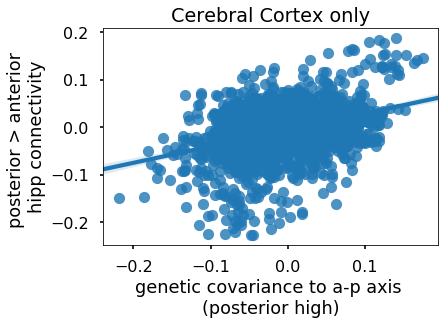

r2 = 0.132236279183, p = 1.80426495986e-64


In [98]:
plt.close()
sns.regplot(np.array(g_cx), np.array(f_cx))
plt.title('Cerebral Cortex only')
plt.xlabel('genetic covariance to a-p axis \n(posterior high)')
plt.ylabel('posterior > anterior \nhipp connectivity')
plt.show()

r, p = stats.pearsonr(np.array(g_cx), np.array(f_cx))
print('r2 = %s, p = %s'%(r**2,p))

In [88]:
labs = pandas.read_csv('/Users/jakevogel/git/pycourse_vuMC/stuff/dst_labels.csv', header=None)
    ...: labs.columns = ['integer_label', 'label']
    ...: labs.loc[78:]

,integer_label,label
78,79,L Cerebellum
79,80,R Cerebellum


In [93]:
# WITHOUT CEREBELLUM BUT WITH SUBCORTEX
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0
gmsk = np.array(gx_img, copy=True)
gmsk[msk2 == 0] = 0
g_cx = []
f_cx = []
for i,row in gdf.iterrows():
    coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
    coord = [round(x) for x in coord]
    if msk2[coord[0],coord[1],coord[2]] != 0:
        xs,ys,zs = make_sphere(coord, 5)
        val = poa[xs,ys,zs]
        f_cx.append(val.mean())
        g_cx.append(row['genetic_connectivity'])

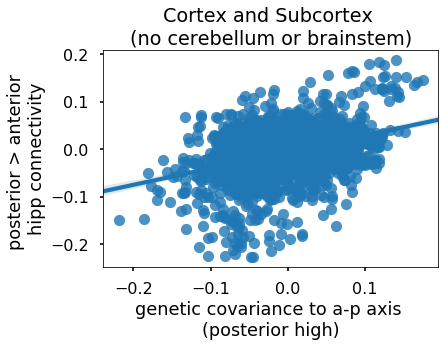

r2 = 0.132236279183, p = 1.80426495986e-64


In [99]:
# WITHOUT CEREBELLUM BUT WITH SUBCORTEX
plt.close()
sns.regplot(np.array(g_cx), np.array(f_cx))
plt.title('Cortex and Subcortex \n(no cerebellum or brainstem)')
plt.xlabel('genetic covariance to a-p axis \n(posterior high)')
plt.ylabel('posterior > anterior \nhipp connectivity')
plt.show()

r, p = stats.pearsonr(np.array(g_cx), np.array(f_cx))
print('r2 = %s, p = %s'%(r**2,p))

In [109]:
print(labs.loc[35])
print(labs.loc[74])

integer_label              36
label             Hippocampus
Name: 35, dtype: object
integer_label              75
label             Hippocampus
Name: 74, dtype: object


In [103]:
labs[labs.label=='Hippocampus']

,integer_label,label


In [111]:
# SAME BUT EXCLUDING HIPPOCAMPUS
msk3 = np.array(msk2, copy=True)
msk3[dkt==36] = 0
msk3[dkt==75] = 0
g_cx = []
f_cx = []
for i,row in gdf.iterrows():
    coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
    coord = [round(x) for x in coord]
    if msk3[coord[0],coord[1],coord[2]] != 0:
        xs,ys,zs = make_sphere(coord, 5)
        val = poa[xs,ys,zs]
        f_cx.append(val.mean())
        g_cx.append(row['genetic_connectivity'])

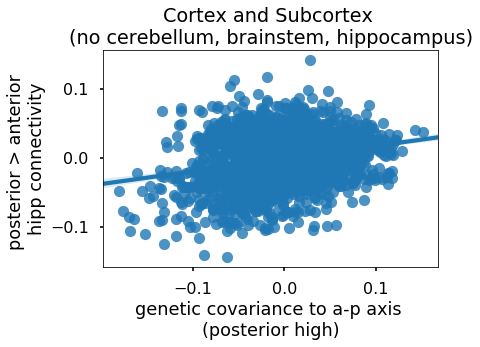

r2 = 0.0635248060209, p = 5.70313343915e-28


In [112]:
# WITHOUT CEREBELLUM BUT WITH SUBCORTEX
plt.close()
sns.regplot(np.array(g_cx), np.array(f_cx))
plt.title('Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)')
plt.xlabel('genetic covariance to a-p axis \n(posterior high)')
plt.ylabel('posterior > anterior \nhipp connectivity')
plt.show()

r, p = stats.pearsonr(np.array(g_cx), np.array(f_cx))
print('r2 = %s, p = %s'%(r**2,p))

In [359]:
cnx = sorted(glob('/Users/jakevogel/Science/AHBA/cx_maps/*/functional*'))
print(len(cnx))
cnx[0]

96


'/Users/jakevogel/Science/AHBA/cx_maps/ant/functional_connectivity_-20_-16_-20.nii'

In [361]:
for i,row in df.iterrows():
    dists = []
    x,y,z = convert_coords([row['x'], row['y'], row['z']],'mni')
    for c in cnx:
        ctch = []
        stg = c.split('_')
        ctch.append(abs(x - int(stg[3])))
        ctch.append(abs(y - int(stg[4])))
        ctch.append(abs(z - int(stg[5].split('.')[0])))
        dists.append(sum(ctch))
    gidx = np.argmin(dists)
    df.loc[i,'closest_cx_map'] = cnx[gidx]

In [363]:
df.head()

,Unnamed: 0,Unnamed: 0.1,sub,label,x,y,z,slab_type,structure_acronym,structure_name,...,5_c_solution,6_c_solution,7_c_solution,8_c_solution,9_c_solution,10_c_solution,11_c_solution,12_c_solution,for_iloc,closest_cx_map
1,1,1,10021,524,118,108,56,CX,DG,"dentate gyrus, left",...,2.0,5.0,5.0,2.0,5.0,6.0,2.0,11.0,0,/Users/jakevogel/Science/AHBA/cx_maps/ant/func...
2,2,2,10021,525,117,108,56,CX,CA4,"CA4 field, left",...,4.0,4.0,3.0,7.0,8.0,9.0,1.0,4.0,1,/Users/jakevogel/Science/AHBA/cx_maps/ant/func...
3,3,3,10021,527,121,109,54,CX,CA1,"CA1 field, left",...,4.0,4.0,3.0,7.0,8.0,9.0,1.0,4.0,2,/Users/jakevogel/Science/AHBA/cx_maps/ant/func...
4,4,4,10021,528,112,109,50,CX,S,"subiculum, left",...,4.0,4.0,3.0,7.0,8.0,9.0,1.0,4.0,3,/Users/jakevogel/Science/AHBA/cx_maps/ant/func...
5,5,5,10021,531,115,91,66,CX,DG,"dentate gyrus, left",...,3.0,3.0,0.0,6.0,1.0,0.0,6.0,5.0,4,/Users/jakevogel/Science/AHBA/cx_maps/post/fun...


In [379]:
# THIS DIDNT WORK
jnk = ni.load(df.closest_cx_map.values[0])
aff = jnk.affine
wtd_mean = np.zeros_like(jnk.get_data())
for i in range(len(rs)):
    cx = df.loc[df.index[i],'closest_cx_map']
    wtd_mean += (ni.load(cx).get_data() * rs[i])
nimg = ni.Nifti1Image(wtd_mean, aff)
nimg.to_filename('/Users/jakevogel/Science/AHBA/cx_maps/p-a_weighted_cx_map')
    

In [120]:
df.loc[:,'for_iloc'] = range(len(df))

In [127]:
ah_xp = xp.iloc[xp.index[:-6],df[df.hip_axis_loc_posterior_high < 20]['for_iloc']
               ].mean(axis=1)
ph_xp = xp.iloc[xp.index[:-6],df[df.hip_axis_loc_posterior_high > 25]['for_iloc']
               ].mean(axis=1)

In [134]:
betas = pcalr_out['betas']
stats.pearsonr(betas,ah_xp)

(-0.084451648064305301, 2.3466843052358872e-93)

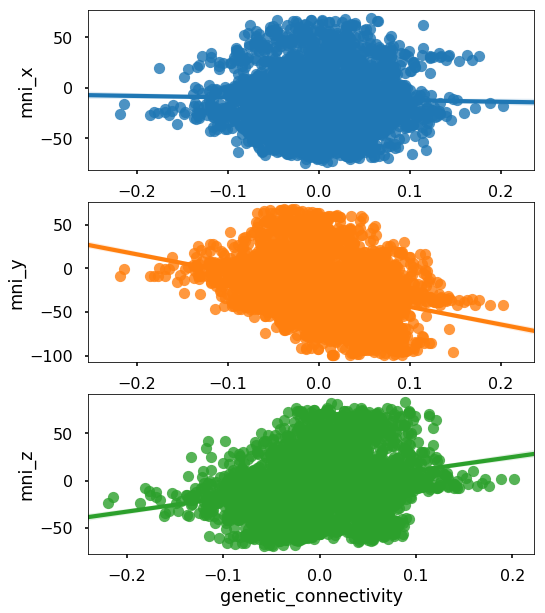

0.000833866355662
0.106578651682
0.0614113833163


In [146]:
plt.close()
fig,(ax1, ax2, ax3) = plt.subplots(3, figsize=(8,10))
sns.regplot(gdf.genetic_connectivity, gdf.mni_x, ax=ax1)
sns.regplot(gdf.genetic_connectivity, gdf.mni_y, ax=ax2)
sns.regplot(gdf.genetic_connectivity, gdf.mni_z, ax=ax3)
plt.show()
print(stats.pearsonr(gdf.genetic_connectivity, gdf.mni_x)[0]**2)
print(stats.pearsonr(gdf.genetic_connectivity, gdf.mni_y)[0]**2)
print(stats.pearsonr(gdf.genetic_connectivity, gdf.mni_z)[0]**2)

In [151]:
frontal = [1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
          ] + [1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
          ] + [0,0]
labs.loc[:,'frontal'] = frontal

In [155]:
len(occipital)

83

In [157]:
occipital = [0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
             ] + [0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
             ] + [0,0]
#list(zip(labs.label,occipital))
labs.loc[:,'occipital'] = occipital

In [158]:
labs.head()

,integer_label,label,frontal,occipital
0,1,Caudal anterior cingulate,1,0
1,2,Caudal middle frontal,1,0
2,3,Cuneus,0,1
3,4,entorinal,0,0
4,5,fusiform,0,0


In [159]:
flobe = np.zeros_like(dkt)
olobe = np.zeros_like(dkt)
for i,row in labs.iterrows():
    if row['frontal'] == 1:
        flobe[dkt==row['integer_label']] = 1
    elif row['occipital'] == 1:
        olobe[dkt==row['integer_label']] = 1


In [180]:
ocoords = np.where(olobe==1)
ohits = [[ocoords[0][x], ocoords[1][x], ocoords[2][x]] for x in range(len(ocoords[0]))]

fcoords = np.where(flobe==1)
fhits = [[fcoords[0][x], fcoords[1][x], fcoords[2][x]] for x in range(len(fcoords[0]))]

In [181]:
for i,row in gdf.iterrows():
    tcoords = [int(x) for x in convert_coords([round(row['mni_x']),
                                   round(row['mni_y']),round(row['mni_z'])
                                  ],'xyz')]
    if tcoords in ohits:
        gdf.loc[i,'frontal1_occipital0'] = 0
        print('hit occipital')
    elif tcoords in fhits:
        print('hit frontal')
        gdf.loc[i,'frontal1_occipital0'] = 1

hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit occipital
hit occipital
hit occipital
hit frontal
hit frontal
hit frontal
hit occipital
hit occipital
hit frontal
hit frontal
hit frontal
hit frontal
hit frontal
hit occipital
hit occipital
hit occipital
hit occipital
hit frontal
hit frontal
hit frontal
hit occipital
hit occipital
hit occipital
hit occipital
hit frontal
hit frontal
hit frontal
hit frontal
hit occipital
hit occipita

In [185]:
f_o_classifier = gdf[pandas.notnull(gdf.frontal1_occipital0)
                    ][['genetic_connectivity','frontal1_occipital0']]
f_o_classifier.shape

(613, 2)

In [189]:
f_o_classifier.genetic_connectivity.values.reshape(-1,1)

array([[ -2.33942206e-02],
       [ -3.28984342e-02],
       [ -1.31703574e-01],
       [ -1.44753901e-03],
       [ -1.42637741e-02],
       [ -1.20755861e-02],
       [ -5.55912807e-02],
       [ -3.95863207e-02],
       [ -5.78008200e-02],
       [ -3.77200806e-02],
       [ -4.88431055e-02],
       [ -5.25666500e-02],
       [ -3.08236327e-02],
       [ -6.78528950e-02],
       [ -4.13839601e-02],
       [ -5.36966016e-02],
       [ -6.15175641e-02],
       [ -6.43969964e-02],
       [  2.78385714e-04],
       [ -1.38039516e-02],
       [ -5.90796330e-02],
       [ -5.93232896e-02],
       [ -2.92732439e-02],
       [ -2.71116282e-03],
       [ -6.43454952e-02],
       [ -7.43631578e-02],
       [ -4.74899930e-02],
       [ -2.70203483e-02],
       [  4.90805172e-03],
       [ -6.71412193e-02],
       [ -6.87377659e-02],
       [ -3.73171219e-02],
       [ -2.67308408e-02],
       [ -4.58643663e-02],
       [ -5.53294632e-02],
       [ -2.52827870e-02],
       [  6.36240917e-03],
 

In [196]:
fo_mod = linear_model.LogisticRegressionCV().fit(
        f_o_classifier.genetic_connectivity.values.reshape(-1,1),
                                       f_o_classifier.frontal1_occipital0.values)
fo_mod.score(f_o_classifier.genetic_connectivity.values.reshape(-1,1),
             f_o_classifier.frontal1_occipital0)

0.83849918433931481

In [222]:
gdf.to_csv(os.path.join(wdir,'gxp_correlation_wholebrain_results.csv'))

In [228]:
# brainstem cerebellum
for i,row in gdf.iterrows():
    if row['slab_type'] == 'CB':
        gdf.loc[i,'cereb0_bstem1'] = 0
    elif row['slab_type'] == 'BS':
        gdf.loc[i,'cereb0_bstem1'] = 1

In [231]:
c_b_classifier = gdf[pandas.notnull(gdf.cereb0_bstem1)
                    ][['genetic_connectivity','cereb0_bstem1']]
c_b_classifier.shape

(954, 2)

In [230]:
cb_mod = linear_model.LogisticRegressionCV().fit(
        c_b_classifier.genetic_connectivity.values.reshape(-1,1),
                                       c_b_classifier.cereb0_bstem1.values)
cb_mod.score(c_b_classifier.genetic_connectivity.values.reshape(-1,1),
             c_b_classifier.cereb0_bstem1)

0.92557651991614254

running PCA
transforming data
performing model cross-validation
model cv score: r2 =  0.508472846755
running final model
running sanity_check
posterior 1 genes vs. y:  r2 = 0.0696195712919, p = 0.00306571611487 


anterior 1 genes vs. y:  r2 = 0.164617974572, p = 2.94008173355e-06 


posterior 2 genes vs. y:  r2 = 0.249375658675, p = 3.55015420152e-09 


anterior 2 genes vs. y:  r2 = 0.166831809951, p = 2.48540733269e-06 


posterior 5 genes vs. y:  r2 = 0.369437619932, p = 7.10759823993e-14 


anterior 5 genes vs. y:  r2 = 0.467817786493, p = 2.03523814471e-18 


posterior 10 genes vs. y:  r2 = 0.471787321724, p = 1.28379951662e-18 


anterior 10 genes vs. y:  r2 = 0.566908593487, p = 6.4540285173e-24 


posterior 20 genes vs. y:  r2 = 0.36005970628, p = 1.7708024615e-13 


anterior 20 genes vs. y:  r2 = 0.569774110622, p = 4.2943918529e-24 


posterior 50 genes vs. y:  r2 = 0.370103177615, p = 6.6584175471e-14 


anterior 50 genes vs. y:  r2 = 0.632036131981, p = 2.94848476617e-28 



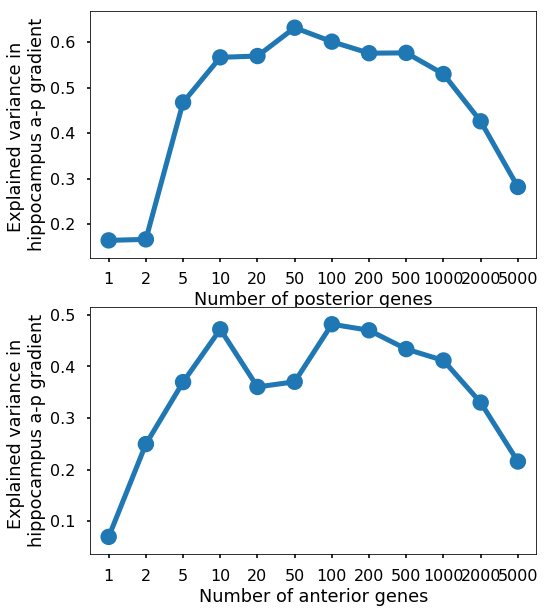

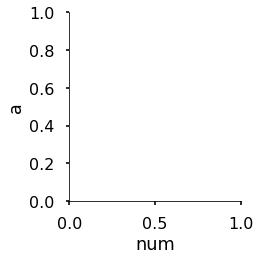

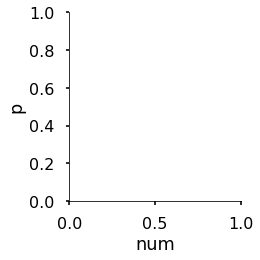

In [266]:
pcalr_out_2 = PCA_LR_pipeline(xp.loc[xp.index[:-6]].values.T, 
                            df.hip_axis_loc_posterior_high, 
                            cv_strategy='score', illustrative=False,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000] )

In [268]:
len(betas)

58692

In [271]:
for_ranking = pandas.DataFrame(index = range(len(betas)), columns = ['Symbol', 'Beta'])
for_ranking.loc[:,'Beta'] = betas
for_ranking.loc[:,'Symbol'] = probes.gene_symbol.values
for_ranking.head()

,Symbol,Beta
0,C8G,0.000416
1,C9,0.000005
2,C9,-0.000025
3,MRPL49,-0.000857
4,MRPL49,-0.000064


In [273]:
for_ranking.to_csv('/Users/jakevogel/Science/AHBA/GSEA_ranking.rnk',index=None, sep='\t')

In [279]:
agenes = pcalr_out['gene_selections']['anterior_genes']
for g in agenes:
    sym = for_ranking.loc[g,'Symbol']
    print(for_ranking.loc[g])
    allgs = for_ranking[for_ranking.Symbol==sym]['Beta']
    if len(allgs) > 1:
        print(allgs)
        print('mean = ',allgs.mean())
    print('\n\n')
    

Symbol        IGFBP6
Beta     -0.00589265
Name: 3011, dtype: object
3010   -0.001715
3011   -0.005893
Name: Beta, dtype: float64
mean =  -0.0038038222027626826



Symbol    A_32_P115840
Beta       -0.00589966
Name: 54487, dtype: object



Symbol        SEMA3D
Beta     -0.00591418
Name: 23553, dtype: object
23551   -0.006776
23552    0.000185
23553   -0.005914
Name: Beta, dtype: float64
mean =  -0.0041682835871147995



Symbol        IGFBP5
Beta     -0.00591681
Name: 3009, dtype: object
3007   -0.003884
3008   -0.004628
3009   -0.005917
Name: Beta, dtype: float64
mean =  -0.0048095641430041984



Symbol         CHRM5
Beta     -0.00591725
Name: 47032, dtype: object
47031   -0.002903
47032   -0.005917
47033   -0.003040
47034   -0.004774
Name: Beta, dtype: float64
mean =  -0.004158699476757425



Symbol      ADAMTSL1
Beta     -0.00593635
Name: 32963, dtype: object
20595    0.000327
32963   -0.005936
32964    0.000506
32965   -0.002878
Name: Beta, dtype: float64
mean =  -0.00199531261577900

In [282]:
len(for_ranking.Symbol.unique())

29131

In [284]:
np.median([5,7])

6.0

In [285]:
for_ranking2 = pandas.DataFrame(index = for_ranking.Symbol.unique(), columns = ['Beta'])
for i,sym in enumerate(for_ranking.Symbol.unique()):
    for_ranking2.loc[sym,'Beta'] = for_ranking[for_ranking.Symbol==sym]['Beta'].median()
    if i%1000 == 0:
        print(i)
for_ranking2.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


,Beta
C8G,0.00123669
C9,-9.96701e-06
MRPL49,-6.36803e-05
ZNHIT2,0.000759301
MPPED2,0.00128304


In [293]:
for_ranking2.loc[:,'Symbol'] = for_ranking2.index
for_ranking2 = for_ranking2.reindex(columns=['Symbol','Beta'])

In [294]:
for_ranking2.to_csv('/Users/jakevogel/Science/AHBA/GSEA_1pergene_ranking.rnk',
                   index=False, sep='\t')

## Yasser suggested trying LARS instead

performing model cross-validation
model cv score: r2 =  0.55913371615
running final model
running sanity_check
posterior 1 genes vs. y:  r2 = 0.230954410927, p = 1.61512575887e-08 


anterior 1 genes vs. y:  r2 = 0.375077538594, p = 4.07896068924e-14 


posterior 2 genes vs. y:  r2 = 0.174672151538, p = 1.36693294397e-06 


anterior 2 genes vs. y:  r2 = 0.55635493254, p = 2.82891072711e-23 


posterior 5 genes vs. y:  r2 = 0.2356938537, p = 1.09723081489e-08 


anterior 5 genes vs. y:  r2 = 0.61327514888, p = 6.21423682378e-27 


posterior 10 genes vs. y:  r2 = 0.396478979807, p = 4.74042281924e-15 


anterior 10 genes vs. y:  r2 = 0.719878684247, p = 1.6443855246e-35 


posterior 20 genes vs. y:  r2 = 0.427972416687, p = 1.73793729547e-16 


anterior 20 genes vs. y:  r2 = 0.759753452252, p = 1.36936650995e-39 


posterior 50 genes vs. y:  r2 = 0.229456330309, p = 1.82426089726e-08 


anterior 50 genes vs. y:  r2 = 0.399539749185, p = 3.46349623784e-15 


posterior 100 genes vs. y:  r2

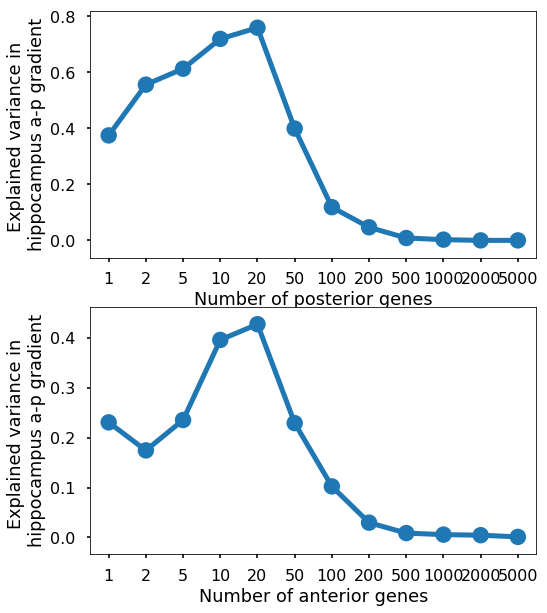

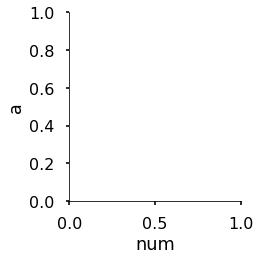

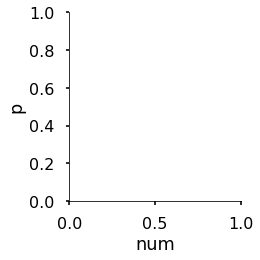

In [320]:
pcalr_out_3 = PCA_LR_pipeline(xp.loc[xp.index[:-6]].values.T, 
                            df.hip_axis_loc_posterior_high,
                              pca=None, clf = linear_model.LassoLarsCV(),
                            cv_strategy='score', illustrative=False,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000] )

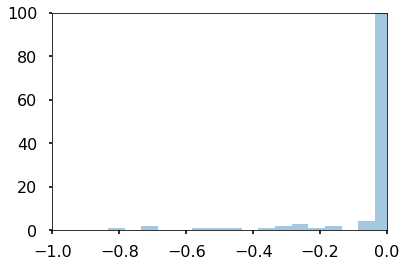

In [326]:
plt.close()
sns.distplot(pcalr_out_3['betas'],kde=False)
plt.xlim(-1,0)
plt.ylim(0,100)
plt.show()

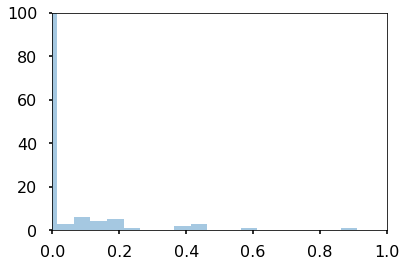

In [327]:
plt.close()
sns.distplot(pcalr_out_3['betas'],kde=False)
plt.xlim(0,1)
plt.ylim(0,100)
plt.show()

In [331]:
pcalr_out_3['gene_selections'].keys()

dict_keys(['posterior_genes_5000', 'anterior_genes_5000'])

In [297]:
xp.loc[xp.index[:-6]].values.T.shape

(124, 58692)

performing model cross-validation
no valid cross-validation method specified
running final model
running sanity_check
posterior 1 genes vs. y:  r2 = 0.230954410927, p = 1.61512575887e-08 


anterior 1 genes vs. y:  r2 = 0.375077538594, p = 4.07896068924e-14 


posterior 2 genes vs. y:  r2 = 0.174672151538, p = 1.36693294397e-06 


anterior 2 genes vs. y:  r2 = 0.55635493254, p = 2.82891072711e-23 


posterior 5 genes vs. y:  r2 = 0.2356938537, p = 1.09723081489e-08 


anterior 5 genes vs. y:  r2 = 0.61327514888, p = 6.21423682378e-27 


posterior 10 genes vs. y:  r2 = 0.396478979807, p = 4.74042281924e-15 


anterior 10 genes vs. y:  r2 = 0.719878684247, p = 1.6443855246e-35 


posterior 20 genes vs. y:  r2 = 0.427972416687, p = 1.73793729547e-16 


anterior 20 genes vs. y:  r2 = 0.759753452252, p = 1.36936650995e-39 


posterior 50 genes vs. y:  r2 = 0.229456330309, p = 1.82426089726e-08 


anterior 50 genes vs. y:  r2 = 0.399539749185, p = 3.46349623784e-15 


posterior 100 genes vs.

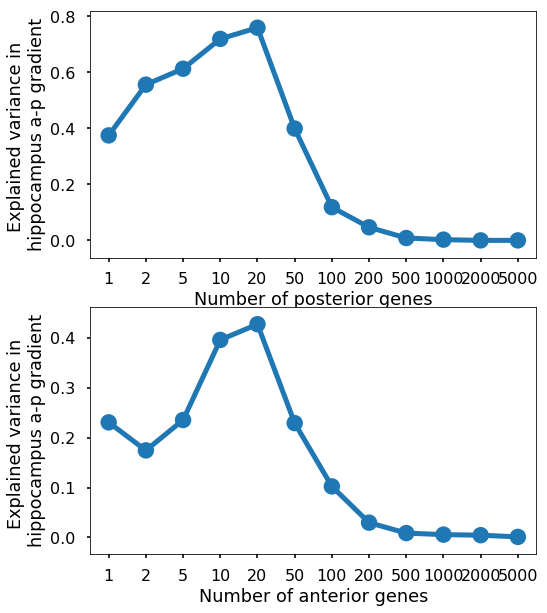

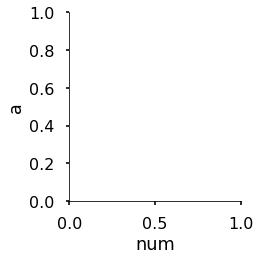

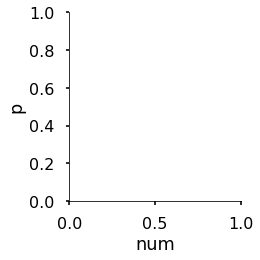

In [335]:
pcalr_out_3 = PCA_LR_pipeline(xp.loc[xp.index[:-6]].values.T, 
                            df.hip_axis_loc_posterior_high,
                              pca=None, clf = linear_model.LassoLarsCV(),
                            cv_strategy=None, illustrative=False,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000] )

In [339]:
probes.loc[pcalr_out_3['gene_selections']['posterior_genes_20']]

,probe_id,probe_name,gene_id,gene_symbol,gene_name,entrez_id,chromosome
25016,1031448,A_23_P368484,122934,C17orf76,"family with sequence similarity 211, member A",388341.0,17
8892,1048608,A_32_P53524,9287,NTN1,netrin 1,9423.0,17
17357,1040666,A_32_P390781,36728,REXO1,"REX1, RNA exonuclease 1 homolog (S. cerevisiae)",57455.0,19
38643,1016111,A_23_P422115,79732,C9orf116,chromosome 9 open reading frame 116,138162.0,9
53066,1065549,A_24_P229025,2875,GRIA3,"glutamate receptor, ionotropic, AMPA 3",2892.0,X
33152,1022035,A_24_P118452,81727,SEPHS1P1,selenophosphate synthetase 1 pseudogene 1,168474.0,7
32889,1023030,A_23_P253896,90297,NPNT,nephronectin,255743.0,4
41301,1013379,CUST_11433_PI416261804,60262,PRDM6,PR domain containing 6,93166.0,5
44603,1059281,CUST_2884_PI416261804,211,ALCAM,activated leukocyte cell adhesion molecule,214.0,3
28658,1027488,A_24_P229350,59995,FMNL3,formin-like 3,91010.0,12


In [445]:
pcalr_out['gene_selections']

{'anterior_genes_100': Int64Index([ 3011, 54487, 23553,  3009, 47032, 32963, 46817, 46816,  3403,
              8403, 44853,  4984,  8441, 23351,  3405, 22938, 33560,  8448,
             49834, 25592, 11928, 55893,  6728, 29196,  3404, 47041, 42892,
             24484, 44179, 33442, 11605, 35456, 35940,  8230, 10216, 56375,
             35035,  8447, 42596, 23551, 56215,  3668, 25455, 25839,  1939,
              4398, 15471, 11603, 32711, 35522, 34958, 23817, 44020, 40112,
              8442, 24685, 22108, 27224, 26855, 42730, 43970,  8692,  6189,
             40303,  1940, 24482, 15811,  8691, 35503, 44435, 35520, 40987,
             34235, 47645, 40910, 37571,  3225,  1954,  2781,  3182, 35379,
             52670, 44735, 25771, 51984, 15812, 28306, 28521, 36265, 14245,
             14246, 20529, 53734, 25772, 14244, 23274, 22478, 25103,  4417,
              4418],
            dtype='int64'),
 'posterior_genes_100': Int64Index([ 6582, 51664, 32888, 32889, 16389, 16390,  8892, 43820,  

In [448]:
p20_LARS = probes.loc[pcalr_out_3['gene_selections']['posterior_genes_20']]
p20_LARS.to_csv('/Users/jakevogel/Science/AHBA/p20_LARS.csv')
a20_LARS = probes.loc[pcalr_out_3['gene_selections']['anterior_genes_20']]
a20_LARS.to_csv('/Users/jakevogel/Science/AHBA/a20_LARS.csv')
p100_SPCR = probes.loc[pcalr_out['gene_selections']['posterior_genes_100']]
p100_SPCR.to_csv('/Users/jakevogel/Science/AHBA/p100_SPCR.csv')
a100_SPCR = probes.loc[pcalr_out['gene_selections']['anterior_genes_100']]
a100_SPCR.to_csv('/Users/jakevogel/Science/AHBA/a100_SPCR.csv')

In [578]:
gdf = pandas.read_csv('/Users/jakevogel/Science/AHBA/gxp_correlation_wholebrain_results.csv',
                     index_col = 0)
gdf.drop(gdf.columns[0],axis=1,inplace=True)
gdf.head()

,Unnamed: 0.1.1,genetic_connectivity,donor,sample,structure_id,slab_num,well_id,slab_type,structure_acronym,structure_name,...,GABRQ_expression,CHRNA1_expression,HTR2C_2451_expression,HTR2C_2438_expression,HTR2C_2436_expression,HTR2C_2439_expression,HTR2C_2455_expression,HTR2C_2461_expression,100_SPCR_axis_expression,20_LARS_axis_expression
0,0,-0.116131,10021,1,4322,10,5705,CX,Cl,"claustrum, left",...,-0.823065,-0.140196,2.180162,-0.127044,2.232565,1.081476,2.565182,3.365207,-0.358414,-0.832941
1,1,-0.018835,10021,2,4291,10,5713,CX,Acb,"nucleus accumbens, left",...,-0.791107,-0.758398,4.315452,2.978550,3.913459,3.894835,4.332273,5.114438,1.285890,0.122228
2,2,-0.002381,10021,3,4292,10,5721,CX,Acb,"nucleus accumbens, right",...,-0.069687,-0.758398,4.704983,3.219912,4.405147,3.012452,5.623632,5.555281,1.053970,0.845136
3,3,-0.031887,10021,4,4292,11,5729,CX,Acb,"nucleus accumbens, right",...,0.557706,-0.758398,3.769962,2.843571,3.508071,3.804379,4.114707,4.572618,0.557374,0.007538
4,4,-0.039106,10021,5,4314,11,5737,CX,SI,"substantia innominata, right",...,1.502103,-0.397046,3.510593,2.762360,3.706185,3.188502,3.799714,4.544185,0.768200,0.418666


In [468]:
gdf[gdf.columns[18:22]]

,a100_SPCR_expression,a20_LARS_expression,p100_SPCR_expression,p20_LARS_expression
0,0.186237,0.552915,-0.172176,-0.280026
1,-0.547663,-0.094056,0.738226,0.028172
2,0.396770,-0.049598,1.450740,0.795538
3,0.056044,0.043986,0.613418,0.051524
4,-0.048839,-0.184178,0.719362,0.234488
5,0.359990,0.652950,-0.013253,-0.079674
6,-0.304980,0.207750,0.203118,-0.046028
7,0.894779,0.643299,-0.116302,0.056428
8,0.550664,0.603526,-0.503295,-0.170593
9,0.919419,0.544130,-0.312011,-0.119447


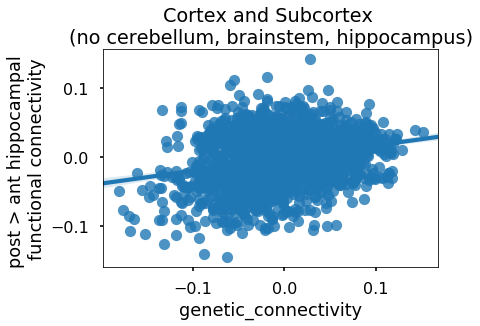

standard statistics: r2 = 0.0635248060209, p = 5.70313343915e-28
permuted p-value =  0.0


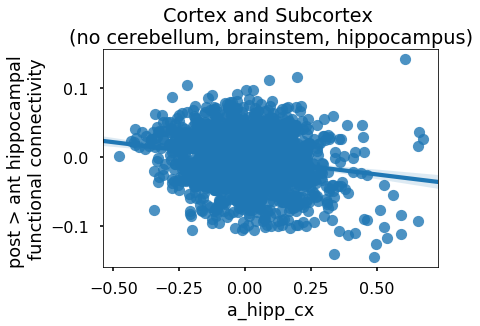

standard statistics: r2 = 0.0363187149767, p = 1.8505424338e-16
permuted p-value =  0.0


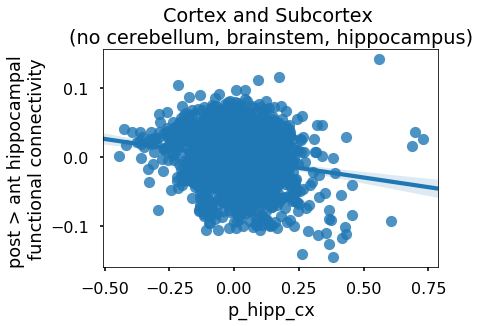

standard statistics: r2 = 0.0356027604334, p = 3.68927336715e-16
permuted p-value =  0.0


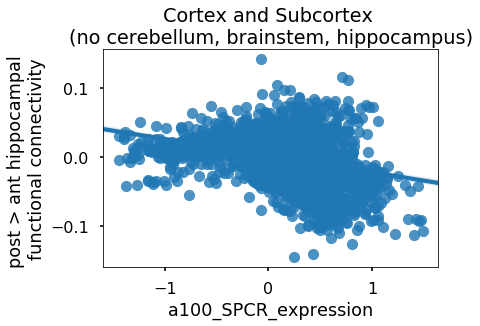

standard statistics: r2 = 0.100470846133, p = 4.41841148279e-44
permuted p-value =  0.0


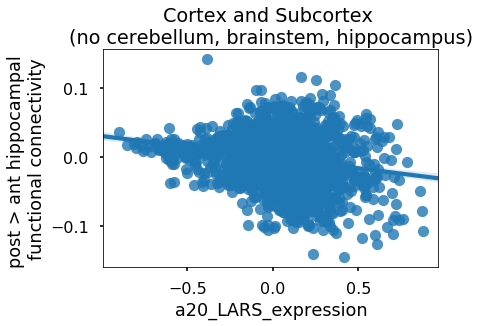

standard statistics: r2 = 0.0404868421541, p = 3.31112561309e-18
permuted p-value =  0.0


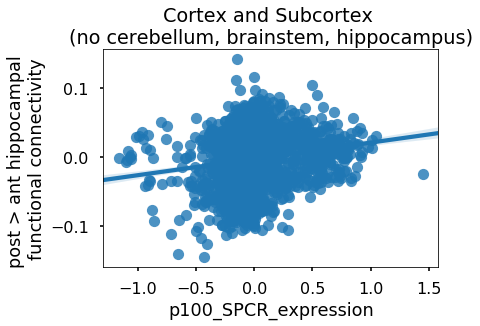

standard statistics: r2 = 0.0339571831923, p = 1.79944446462e-15
permuted p-value =  0.0


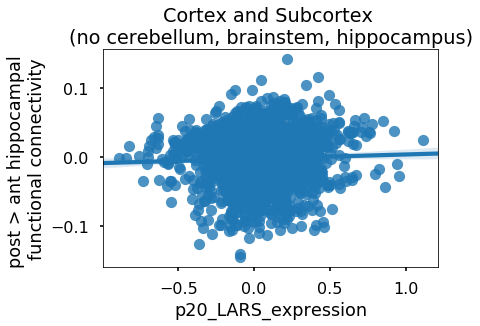

standard statistics: r2 = 0.00156117348348, p = 0.0907215259068
permuted p-value =  0.101


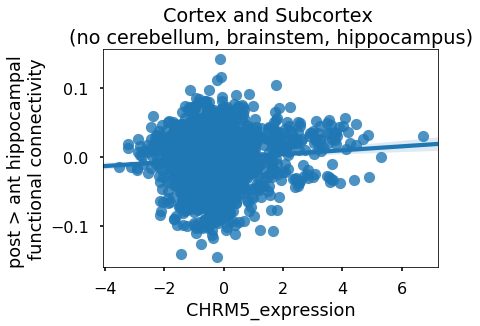

standard statistics: r2 = 0.00767609915492, p = 0.000172148575315
permuted p-value =  0.002


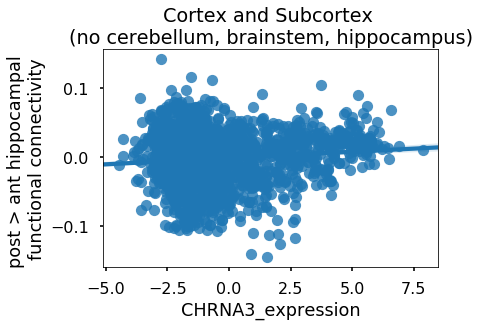

standard statistics: r2 = 0.0110653667069, p = 6.35169051427e-06
permuted p-value =  0.0


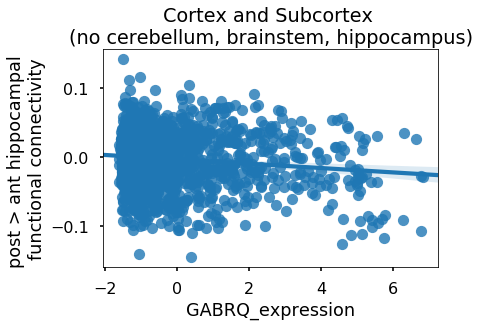

standard statistics: r2 = 0.0150489445314, p = 1.36512106601e-07
permuted p-value =  0.0


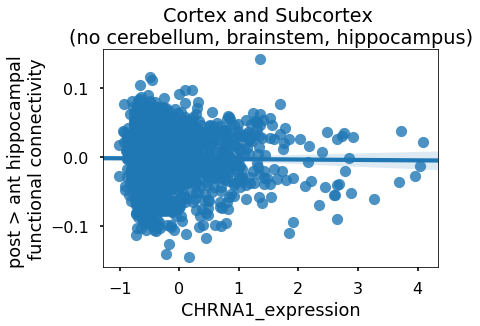

standard statistics: r2 = 9.759867917e-05, p = 0.67244043565
permuted p-value =  0.679


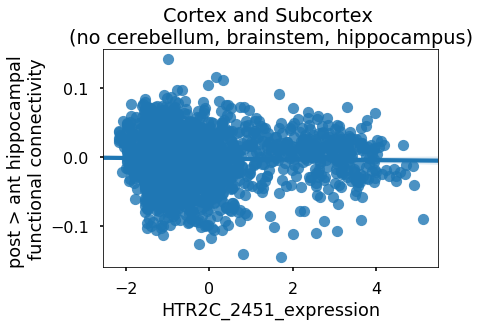

standard statistics: r2 = 0.000420251079053, p = 0.380262945114
permuted p-value =  0.41200000000000003


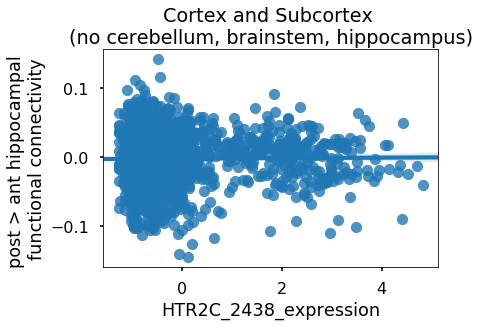

standard statistics: r2 = 0.000105262681839, p = 0.660597373539
permuted p-value =  0.683


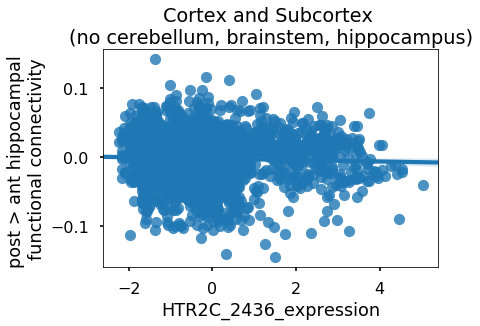

standard statistics: r2 = 0.00138174696352, p = 0.111529070442
permuted p-value =  0.11800000000000001


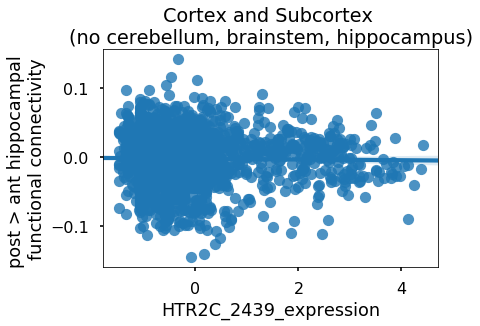

standard statistics: r2 = 0.000265176543823, p = 0.485835897273
permuted p-value =  0.514


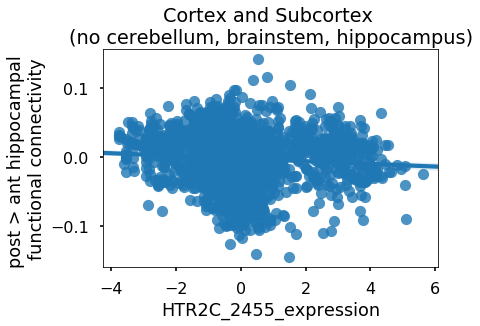

standard statistics: r2 = 0.00689196297216, p = 0.000372299420858
permuted p-value =  0.0


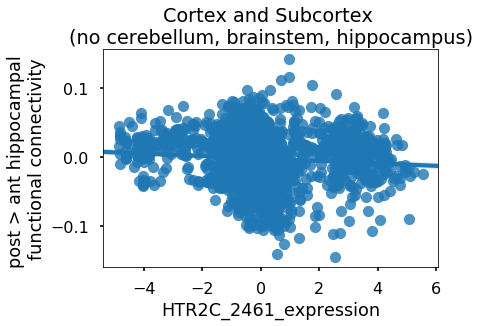

standard statistics: r2 = 0.0075126029594, p = 0.000202119134967
permuted p-value =  0.0


In [534]:
ccols = ['genetic_connectivity'] + gdf.columns[16:].tolist()

for col in ccols:
    plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         col,'post > ant hippocampal \nfunctional connectivity']
    run_gvfcx_analysis(poa, gdf, msk3, 5, col, plabs, bootstrap='permute')

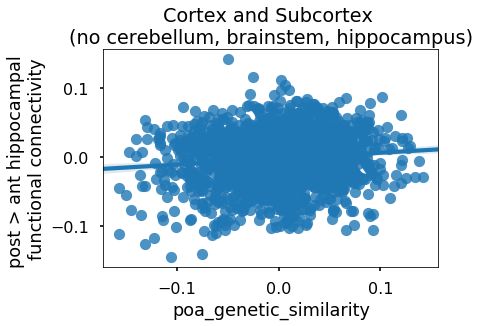

standard statistics: r2 = 0.0120391985107, p = 2.47780673139e-06
permuted p-value =  0.0


In [553]:
gdf.loc[:,'poa_genetic_similarity'] = gdf.p_hipp_cx - gdf.a_hipp_cx
col = 'poa_genetic_similarity'

plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         col,'post > ant hippocampal \nfunctional connectivity']
run_gvfcx_analysis(poa, gdf, msk3, 5, col, plabs, bootstrap='permute')

In [482]:
r, p = stats.pearsonr(np.array(g_cx), np.array(f_cx))
r,p

(-0.10504226790035626, 6.5482432293392886e-06)

running PCA
transforming data
performing model cross-validation


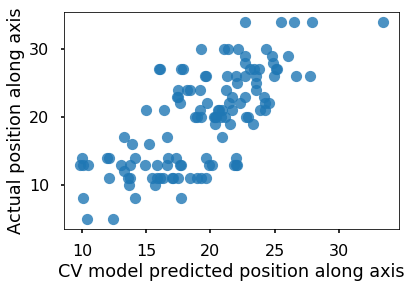

model cv score: r2 =  0.508472846755
running final model
final model fit r2 =  0.821098120088
running sanity_check


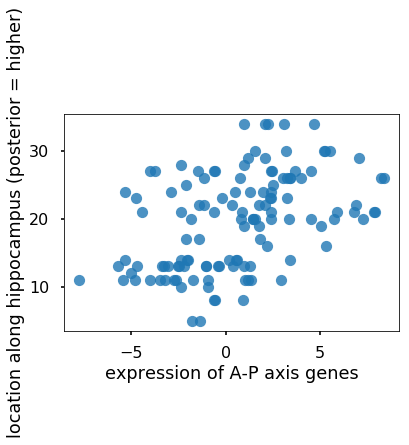

posterior 1 genes vs. y:  r2 = 0.209719413953, p = 8.89974988846e-08 




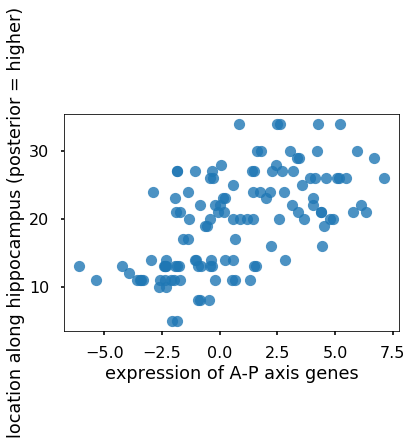

posterior 2 genes vs. y:  r2 = 0.357237622774, p = 2.32475607698e-13 




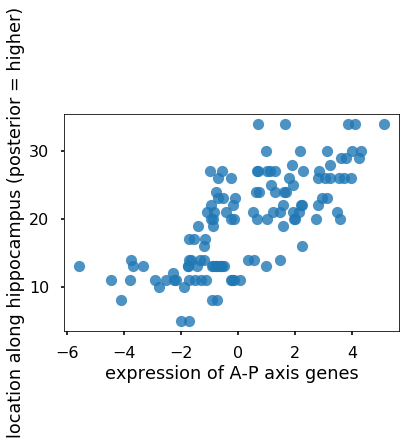

posterior 5 genes vs. y:  r2 = 0.54171638461, p = 2.07617265589e-22 




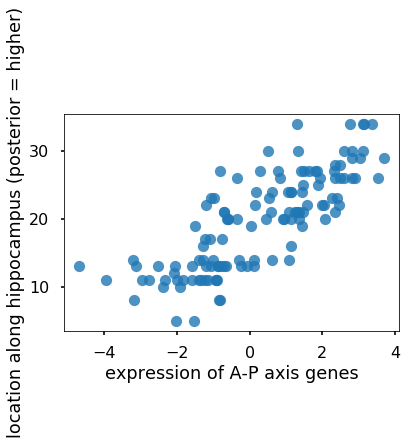

posterior 10 genes vs. y:  r2 = 0.642393423425, p = 5.12597297136e-29 




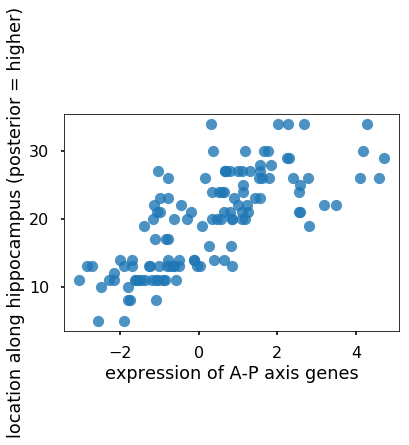

posterior 20 genes vs. y:  r2 = 0.555500894147, p = 3.18341123153e-23 




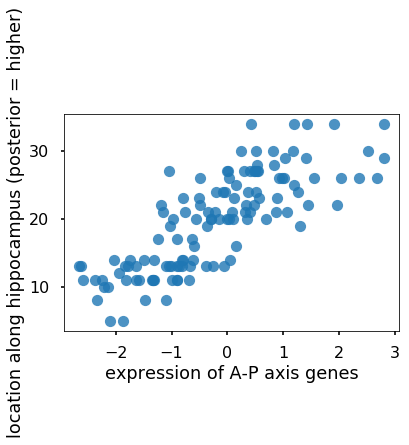

posterior 50 genes vs. y:  r2 = 0.637755237812, p = 1.12902798736e-28 




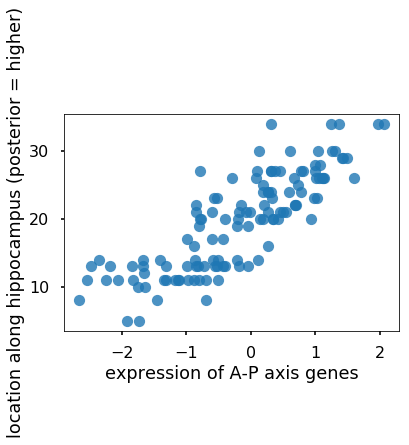

posterior 100 genes vs. y:  r2 = 0.692902401014, p = 4.56937672536e-33 




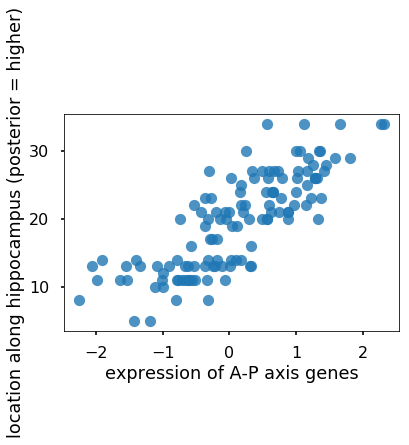

posterior 200 genes vs. y:  r2 = 0.659483772149, p = 2.55202246677e-30 




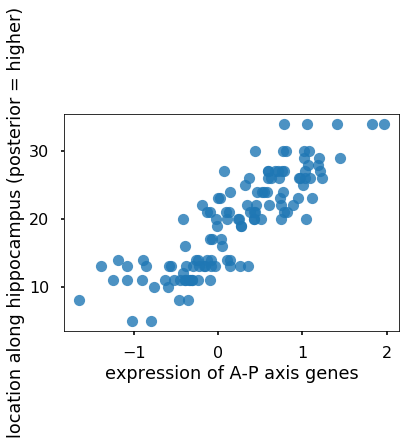

posterior 500 genes vs. y:  r2 = 0.728709024992, p = 2.31662016253e-36 




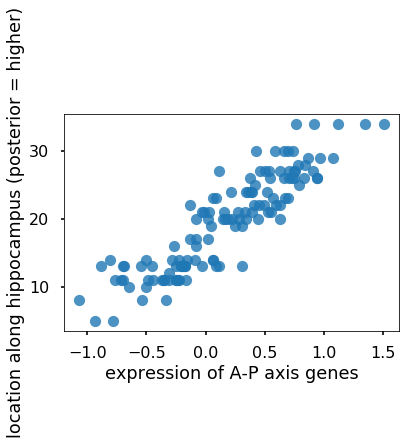

posterior 1000 genes vs. y:  r2 = 0.808226752233, p = 1.42346191281e-45 




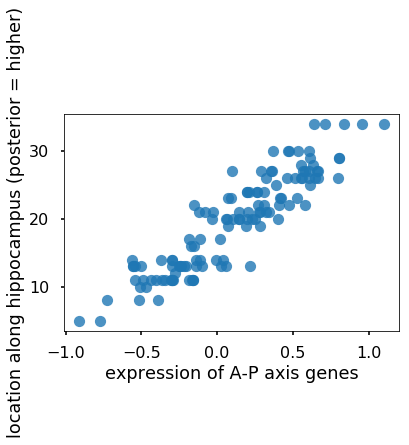

posterior 2000 genes vs. y:  r2 = 0.832340753893, p = 3.86451483619e-49 




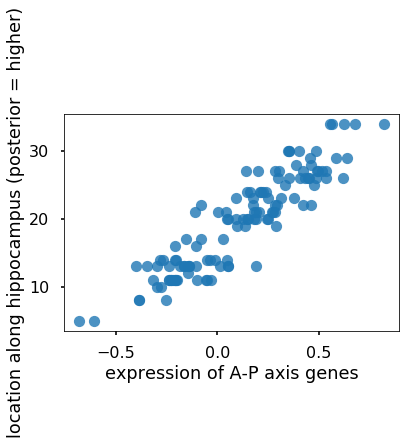

posterior 5000 genes vs. y:  r2 = 0.833636036262, p = 2.40602739327e-49 




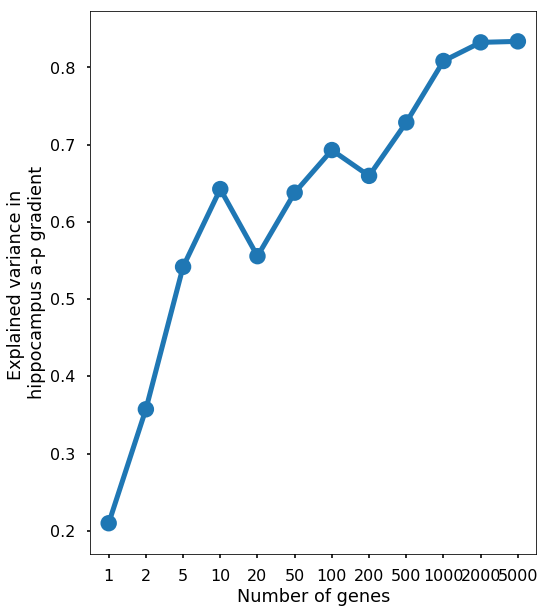

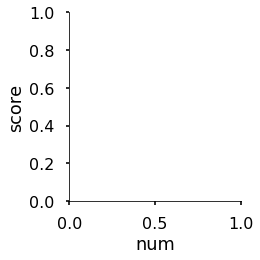

In [572]:
pcalr_out_4 = PCA_LR_pipeline(xp.loc[xp.index[:-6]].values.T, 
                            df.hip_axis_loc_posterior_high, 
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000],
                             sanity_check_style = 'together')

performing model cross-validation
no valid cross-validation method specified
running final model
running sanity_check
posterior 1 genes vs. y:  r2 = 0.527639566295, p = 1.3313862147e-21 


posterior 2 genes vs. y:  r2 = 0.674061337472, p = 1.75037649911e-31 


posterior 5 genes vs. y:  r2 = 0.810749508193, p = 6.33681573126e-46 


posterior 10 genes vs. y:  r2 = 0.875726447803, p = 4.39837031407e-57 


posterior 20 genes vs. y:  r2 = 0.903984072311, p = 6.34393637518e-64 


posterior 50 genes vs. y:  r2 = 0.697483845409, p = 1.82078945516e-33 


posterior 100 genes vs. y:  r2 = 0.617774766878, p = 3.03245715935e-27 


posterior 200 genes vs. y:  r2 = 0.406105714745, p = 1.75722384419e-15 


posterior 500 genes vs. y:  r2 = 0.162921239433, p = 3.34330194437e-06 


posterior 1000 genes vs. y:  r2 = 0.120917723449, p = 7.58365715636e-05 


posterior 2000 genes vs. y:  r2 = 0.0751523826996, p = 0.00206293349843 


posterior 5000 genes vs. y:  r2 = 0.0208488718952, p = 0.109601529225 




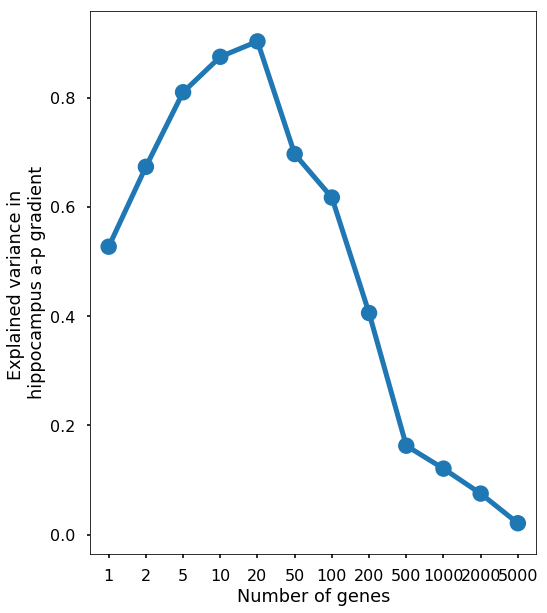

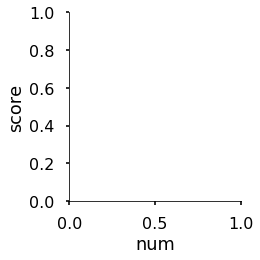

In [573]:
pcalr_out_3 = PCA_LR_pipeline(xp.loc[xp.index[:-6]].values.T, 
                            df.hip_axis_loc_posterior_high,
                              pca=None, clf = linear_model.LassoLarsCV(),
                            cv_strategy=None, illustrative=False,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000],
                             sanity_check_style = 'together')

In [582]:
ccols2 = gdf.columns[-2:]

for col in ccols:
    plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         col,'post > ant hippocampal \nfunctional connectivity']
    run_gvfcx_analysis(poa, gdf, msk3, 5, col, plabs, bootstrap='permute')

In [551]:
def make_expression_image(vector, coords, projection_space, 
                          wdir = './', nm = 'gene', vrad=5):
    if len(vector) != len(coords):
        print('input and coordinate vectors must have the same length')
    if type(projection_space) == str:
        jnk = ni.load(projection_space)
        aff = jnk.affine
        dat = jnk.get_data()
    else:
        try:
            aff = projection_space.affine
            dat = projection_space.get_data()
        except:
            raise IOError('projection_space must be a NiftiImage object or path to .nii file')
    nimg = np.zeros_like(dat).astype(float)
    for i in range(len(vector)):
        xs,ys,zs = make_sphere(coords[i], vrad)
        nimg[xs,ys,zs] = vector[i]
    nimg = ni.Nifti1Image(nimg,aff)
    flnm = os.path.join(wdir,'%s_xp_image.nii.gz'%nm)
    nimg.to_filename(flnm)
    
        

In [550]:
gdf[col].values

array([ 3.36520741,  5.11443803,  5.5552808 , ..., -4.3290577 ,
       -4.27919071, -4.3290577 ])

In [552]:
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz'))

projection_space = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
gdir = '/Users/jakevogel/Science/AHBA/gxp_images'
for col in ccols[1:]:
    if '_expres' in col:
        lab = col.split('_expres')[0]
    else:
        lab = col
    make_expression_image(gdf[col].values, input_coords, projection_space, 
                          wdir = gdir, nm = lab, vrad=5)
    print('finished ',col)

finished  a_hipp_cx
finished  p_hipp_cx
finished  a100_SPCR_expression
finished  a20_LARS_expression
finished  p100_SPCR_expression
finished  p20_LARS_expression
finished  CHRM5_expression
finished  CHRNA3_expression
finished  GABRQ_expression
finished  CHRNA1_expression
finished  HTR2C_2451_expression
finished  HTR2C_2438_expression
finished  HTR2C_2436_expression
finished  HTR2C_2439_expression
finished  HTR2C_2455_expression
finished  HTR2C_2461_expression


In [583]:
for col in ccols2:
    if '_expres' in col:
        lab = col.split('_expres')[0]
    else:
        lab = col
    make_expression_image(gdf[col].values, input_coords, projection_space, 
                          wdir = gdir, nm = lab, vrad=5)
    print('finished ',col)

finished  100_SPCR_axis_expression
finished  20_LARS_axis_expression


In [ ]:
for i,row in gdf.iterrows():
        coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
        coord = [round(x) for x in coord]
        if msk[coord[0],coord[1],coord[2]] != 0:
            xs,ys,zs = make_sphere(coord, vrad)
            val = img[xs,ys,zs]
            f_cx.append(val.mean())
            g_cx.append(row[gcx_col])